In [27]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from IPython.display import display


In [28]:

register_matplotlib_converters()  # to avoid warning message

# Define the ticker symbol
tickerSymbol = 'BTC-USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2015-1-1', end='2024-09-24')

df = tickerDf.reset_index() # reset the index
df = pd.DataFrame(df) # convert the data to a dataframe
df['timestamp'] = df['Date'].apply(lambda x: x.timestamp()) # convert the date to a timestamp, because the LinearRegression model does not accept datetime data

display(df.head())
display(df.describe())

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,timestamp
0,2015-01-01 00:00:00+00:00,320.434998,320.434998,314.002991,314.248993,8036550,0.0,0.0,1.420070e+09
1,2015-01-02 00:00:00+00:00,314.079010,315.838989,313.565002,315.032013,7860650,0.0,0.0,1.420157e+09
2,2015-01-03 00:00:00+00:00,314.846008,315.149994,281.082001,281.082001,33054400,0.0,0.0,1.420243e+09
3,2015-01-04 00:00:00+00:00,281.145996,287.230011,257.612000,264.195007,55629100,0.0,0.0,1.420330e+09
4,2015-01-05 00:00:00+00:00,265.084015,278.341003,265.084015,274.473999,43962800,0.0,0.0,1.420416e+09


,Open,High,Low,Close,Volume,Dividends,Stock Splits,timestamp
count,3554.000000,3554.000000,3554.000000,3554.000000,3.554000e+03,3554.0,3554.0,3.554000e+03
mean,18401.064468,18818.658612,17955.834557,18417.609019,1.816345e+10,0.0,0.0,1.573560e+09
std,19738.090564,20178.234623,19256.699632,19748.249635,1.920922e+10,0.0,0.0,8.865467e+07
min,176.897003,211.731003,171.509995,178.102997,7.860650e+06,0.0,0.0,1.420070e+09
25%,2339.725037,2458.429932,2277.679932,2361.564941,9.687715e+08,0.0,0.0,1.496815e+09
50%,9355.095215,9540.397461,9230.836914,9373.948730,1.471752e+10,0.0,0.0,1.573560e+09
75%,29751.556152,30242.770508,29253.109375,29770.225098,2.902112e+10,0.0,0.0,1.650305e+09
max,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11,0.0,0.0,1.727050e+09


In [29]:

# Drop Dividends and Stock Splits
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       3554 non-null   datetime64[ns, UTC]
 1   Open       3554 non-null   float64            
 2   High       3554 non-null   float64            
 3   Low        3554 non-null   float64            
 4   Close      3554 non-null   float64            
 5   Volume     3554 non-null   int64              
 6   timestamp  3554 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 194.5 KB


None

<Figure size 640x480 with 0 Axes>

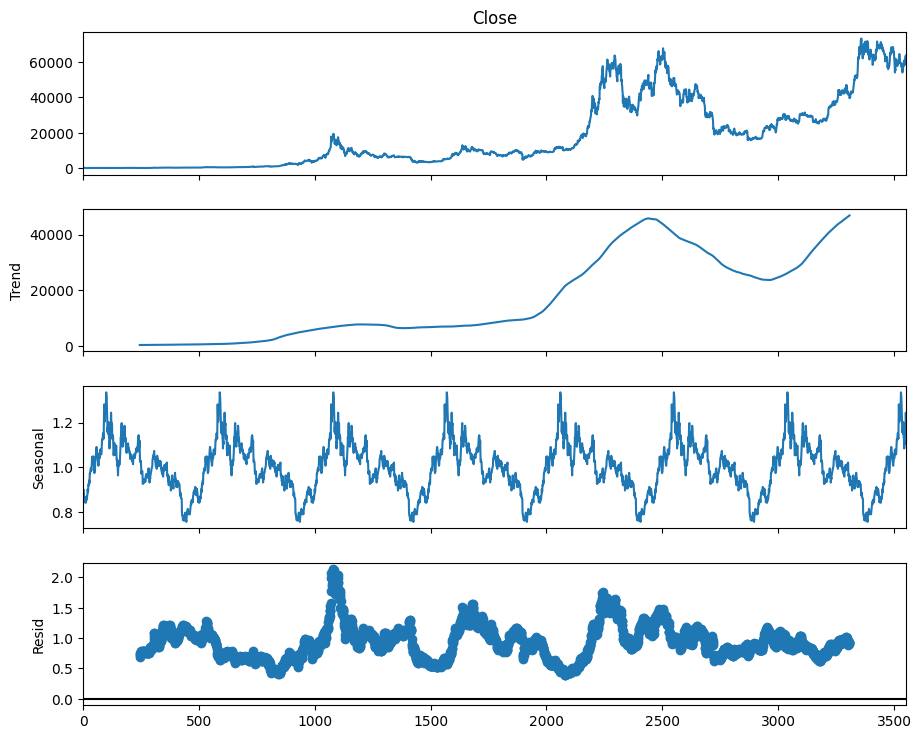

In [30]:

# Examine the BTC price's seasonality, trends, and residuals using time-series decomposition
result = seasonal_decompose(df['Close'], model='multiplicative', period=490)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()

<Figure size 640x480 with 0 Axes>

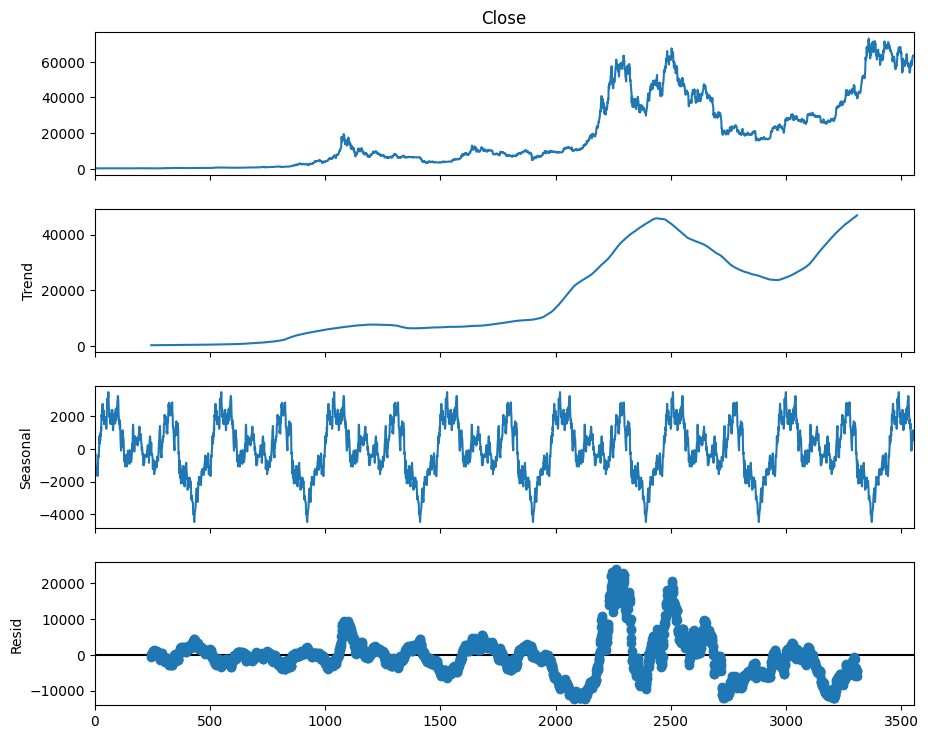

In [31]:
# Examine the BTC price's seasonality, trends, and residuals using time-series decomposition with an additive model instead of multiplicative
#to compare the results
result = seasonal_decompose(df['Close'], model='additive', period=490)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()

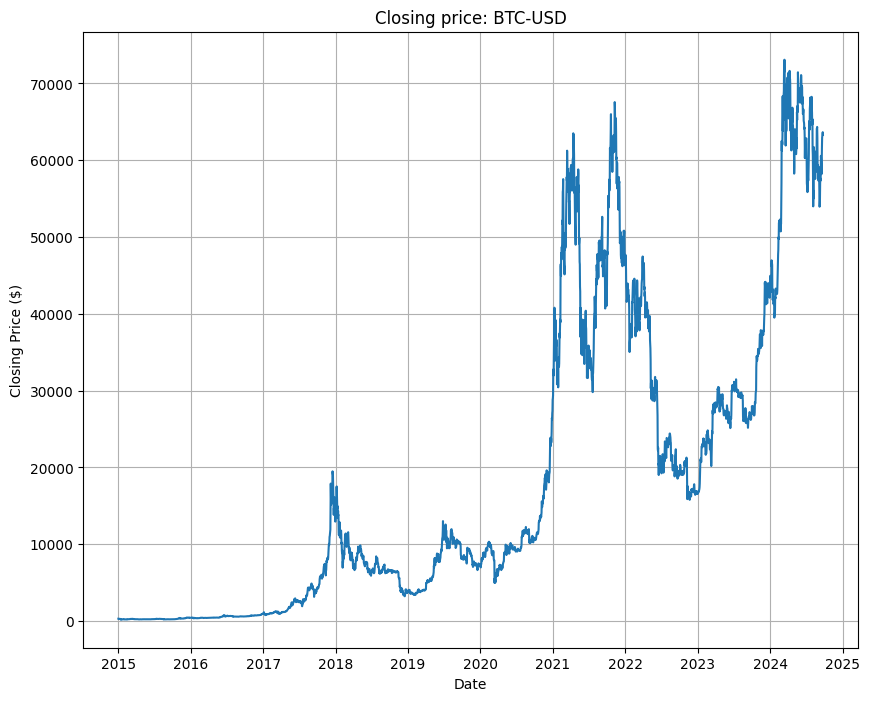

In [32]:

# it looks like the BTC price has a strong seasonality, and the trend is not linear.
# so a linear regression model will not work well with this data.




# Plot the close prices 
plt.figure(figsize=(10, 8))
plt.plot(tickerDf.Close)
plt.title('Closing price: '+tickerSymbol)
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

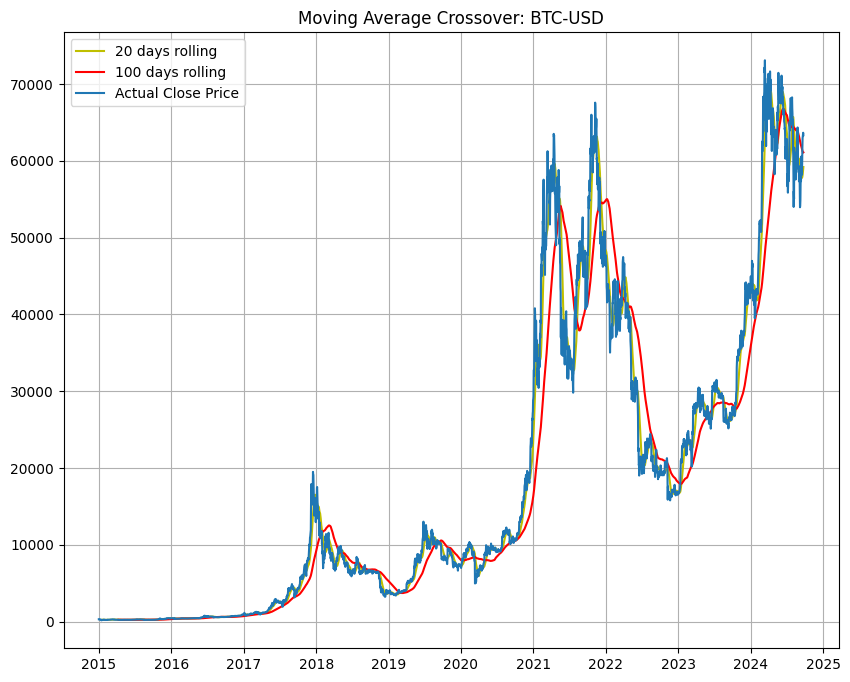

In [33]:

# Moving Average Crossover, with a short window of 20 days and a long window of 100 days
# including the closing price
short_rolling = tickerDf.Close.rolling(window=20).mean() 
long_rolling = tickerDf.Close.rolling(window=100).mean()
plt.figure(figsize=(10,8))
plt.title('Moving Average Crossover: '+tickerSymbol) 
plt.plot(short_rolling, label='20 days rolling', color='y') # yellow
plt.plot(long_rolling, label='100 days rolling', color='r') # red
plt.plot(tickerDf.Close, label='Actual Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [34]:

# split the data into training and test sets
X = tickerDf.drop(['Close'], axis=1)
y = tickerDf['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test because we have a lot of data
display('Training set:', X_train.shape, y_train.shape) 
display('Test set:', X_test.shape, y_test.shape)

'Training set:'

(2843, 6)

(2843,)

'Test set:'

(711, 6)

(711,)

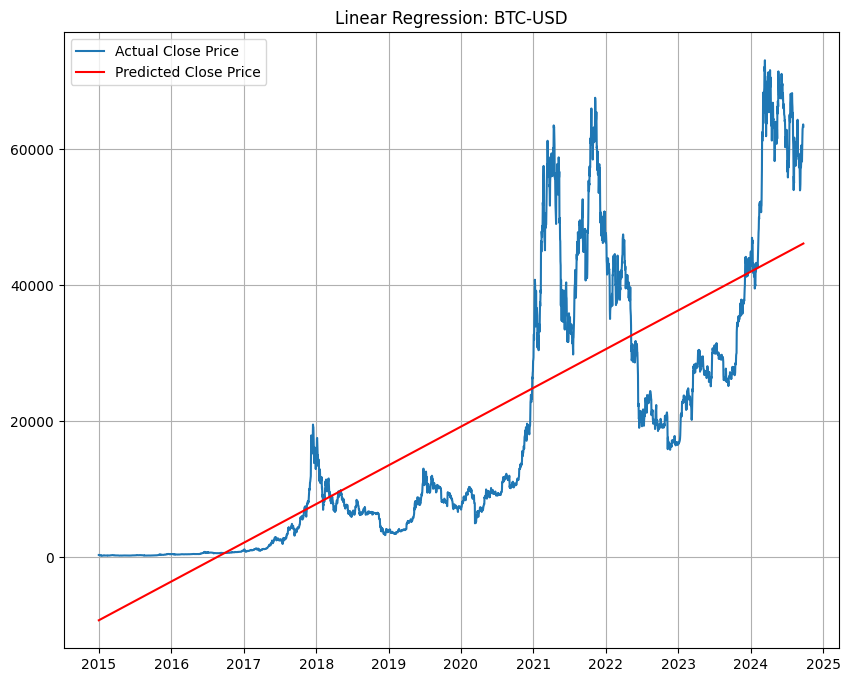

In [35]:

# Linear Regression

X = df['timestamp'].values.reshape(-1, 1) # reshape the data, because we have only one feature
Y = df['Close'].values # the target variable
model = LinearRegression()
model.fit(X, Y)
trend = model.predict(X)
plt.figure(figsize=(10,8))
plt.title('Linear Regression: '+tickerSymbol)
plt.plot(df['Date'], tickerDf.Close, label='Actual Close Price')
plt.plot(df['Date'], trend, label='Predicted Close Price', color='r')
plt.legend()
plt.grid(True)
plt.show()


In [36]:

# evaluating the model
display('Coefficients:', model.coef_)
display('Intercept:', model.intercept_)
display('Mean squared error (MSE): %.2f' % mean_squared_error(Y, trend))
display('R-score: %.2f' % model.score(X, Y))

# we got a very low R-score, which means that the model is not capturing all of the information in the data.
# for a linear regression model to work well, the data should be linear. In this case, the data is not linear, so we need to use a different model.

'Coefficients:'

array([0.00018054])

'Intercept:'

-265668.4466378895

'Mean squared error (MSE): 133780862.96'

'R-score: 0.66'

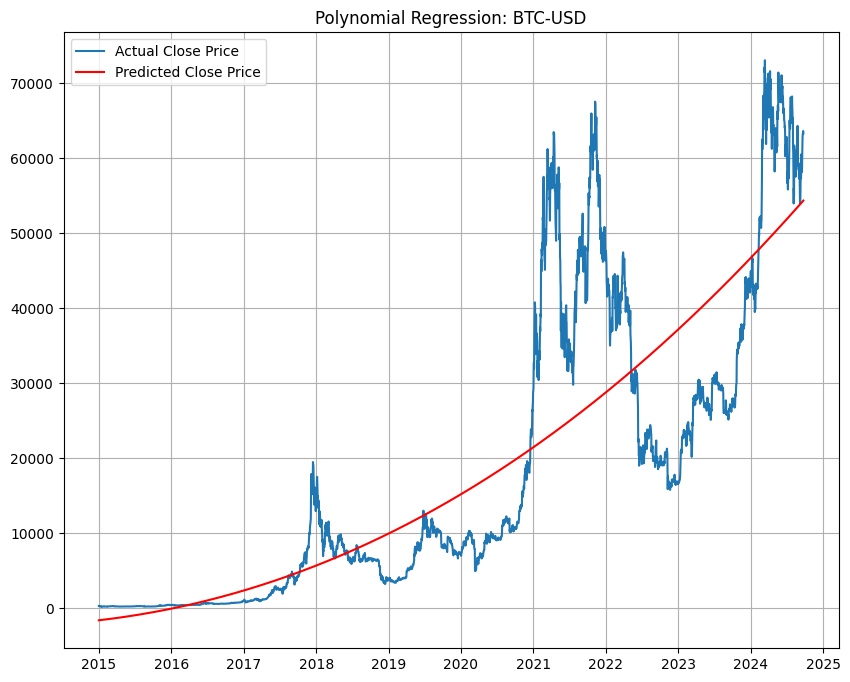

In [37]:


# Polynomial Regression
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
poly.fit(X_poly, Y)
model = LinearRegression()
model.fit(X_poly, Y)
trend = model.predict(X_poly)
plt.figure(figsize=(10,8))
plt.title('Polynomial Regression: '+tickerSymbol)
plt.plot(df['Date'], tickerDf.Close, label='Actual Close Price')
plt.plot(df['Date'], trend, label='Predicted Close Price', color='r')
plt.legend()
plt.grid(True)
plt.show()



In [38]:

# evaluating the model
display('Coefficients:', model.coef_)
display('Intercept:', model.intercept_)
display('Mean squared error (MSE): %.2f' % mean_squared_error(Y, trend))
display('R-score: %.2f' % model.score(X_poly, Y))

# we got a better R-score, but it is still not good enough. We need to use a different model.


'Coefficients:'

array([ 0.00000000e+00, -5.89840440e-20, -3.94273408e-13,  1.90982099e-22])

'Intercept:'

246569.13415731612

'Mean squared error (MSE): 121043810.93'

'R-score: 0.69'